In [2]:
import re
import os
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from pprint import pprint
import math
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.linalg import svd

All of this code was written by ourselves unless otherwise stated.

# Split speech in sentences

### Speeches to sentences with labels

In [3]:
path1 = r"Talerne\Margrethe"
path2 = r"Talerne\Statsministeren"

def sentence_and_label(path):

    sentences = {}

    for file in os.listdir(path):
        filename = os.path.join(path, file)

        # Label the sentence
        if "Margrethe" in file:
            label = 0
        else:
            label = 1

        with open(filename, encoding='utf-8') as speech:
            speech = speech.read()
        
        speech = re.sub("[,*\"'-]"," ",speech)

        speech = speech.lower()

        tokens = nltk.sent_tokenize(speech, language="danish")

        for sentence in tokens:
            sentence = re.sub("[.:;?!`–”«»%…‘’/()]"," ",sentence) 
            sentence = sentence.strip() # Uden mellemrum forrest eller bagerst
            sentences[sentence] = label
        
    return sentences

Margrethe_sentences_with_labels = sentence_and_label(path1)
Statsministeren_sentences_with_labels = sentence_and_label(path2)

In [4]:
from pprint import pprint

# Pretty-print to look nice
pprint(Margrethe_sentences_with_labels)
pprint(Statsministeren_sentences_with_labels)


{'1943  netop det år rummer to væsentlige begivenheder  den 29  august 1943 brød danmark endelig med samarbejdspolitikken  og i oktober samme år lykkedes det at hjælpe størstedelen af de danske jøder til sverige': 0,
 '1972 vil blive et historisk år på mange måder': 0,
 '1972 vil sikkert også komme til at stå som et betydningsfuldt år i verdenshistorien': 0,
 '1973 blev ikke i sin helhed noget fredens år for verden': 0,
 '1982 har nok stillet hårdere krav til os  end vi har været vant til  og der er mange i vort samfund  som har grund til ikke at føle sig særlig forkælede': 0,
 '1983 er ikke bare vores år  det skal også være deres': 0,
 '1984 er der nok mange  der har set hen til med en vis gysen  for ikke sandt  fremtidsromanen  1984   skrevet for mere end tredive år siden  har ved sit knugende billede af et samfund  hvor al frihed og menneskelighed er undertrykt  på en eller anden måde givet en skæbnesvanger klang til det årstal  også for de mange  der ikke selv har læst bogen': 0,
 

### Separate keys and values into two lists (For vectorization)

In [161]:
all_sentences_list = []
all_labels_list = []

# Margrethe sentences
for sent, lab in Margrethe_sentences_with_labels.items():
    all_sentences_list.append(sent)
    all_labels_list.append(lab)

# Statsminister sentences
for sent, lab in Statsministeren_sentences_with_labels.items():
    all_sentences_list.append(sent)
    all_labels_list.append(lab)
# pprint(all_sentences)
print(len(all_sentences_list))

10737


### Split data into training and testing:

This code was written by following the method in this website:

https://www.geeksforgeeks.org/how-to-split-data-into-training-and-testing-in-python-without-sklearn/

In [162]:
df = pd.DataFrame({
    "Sentences": all_sentences_list,
    "Labels": all_labels_list,
})
df

,Sentences,Labels
0,for min familie og for mig selv blev dette år ...,0
1,den dybe sorg der ramte os følte vi at hele...,0
2,de hjertelige følelser som i de tunge dage st...,0
3,1972 vil blive et historisk år på mange måder,0
4,i danmarkshistorien vil året blive husket for ...,0
...,...,...
10732,jeg tror desværre at de kommende år vil byde ...,1
10733,oprustning for at undgå krig er i mine øjne uo...,1
10734,men lad os gøre det på den danske måde,1
10735,socialt retfærdigt og med vores værdier i behold,1


In [163]:
# Shuffle dataframe using sample function
df = df.sample(frac=1)
df

,Sentences,Labels
6061,med vort ja til amsterdamtraktaten sidste år s...,1
2811,i tusindvis strømmede folk til fra hele landet...,0
6980,det gjorde et stærkt indtryk på os alle at se ...,1
6894,og skatten på arbejde er sænket med omkring 10...,1
4098,der er i realiteten krig,1
...,...,...
1494,det fremmede bliver vedkommende på en anden må...,0
1309,det er svært at rumme alt det nye som vælter ...,0
8928,i nutiden kæmper danskere mod undertrykkelse,1
8432,måske har de manglet viljen,1


In [164]:
# Opdel i per label, hvor hver sætning er shuffled.
df_margrethe = df[df["Labels"] == 0]
df_statsminister = df[df["Labels"] == 1]

# 7451 - x = 3286
# x = 4165

# Drop em
df_statsminister = df_statsminister.iloc[:-4165]

df_statsminister.columns = df_margrethe.columns

df_balanced = pd.concat([df_margrethe, df_statsminister], ignore_index=True)

print(df_balanced)

                                              Sentences  Labels
0     i tusindvis strømmede folk til fra hele landet...       0
1     i morgen er der jo atter en dag  solen vil stå...       0
2                                 hvem vil lege med mig       0
3     året rundt er der nogle  som må være vågne og ...       0
4     de gør et stort arbejde ofte under vanskelige ...       0
...                                                 ...     ...
6567  jeg ved godt  at vi i det daglige kan være uen...       1
6568  de drenge har også drømme  men de bliver ofte ...       1
6569  men det afhænger også af den savlighed  hvorme...       1
6570  nu gælder det handling  og vi skal i fællesska...       1
6571                               og nu skal vi videre       1

[6572 rows x 2 columns]


In [165]:
# Shuffle dataframe using sample function
df = df_balanced.sample(frac=1)

,Sentences,Labels
2323,et godt nytår ønsker jeg for hele det grønland...,0
4654,jeg er selv født med det danske samfunds mulig...,1
2343,lad os gå ind i det nye år med øjnene åbne for...,0
4839,men jeg ser sådan på det at det er til gavn f...,1
3409,sådan må det aldrig blive i danmark,1
...,...,...
2351,også for mange af de unge er situationen bekym...,0
3510,danmark kan ikke løse verdens problemer alene,1
2481,tolv måneder er hurtigt forbi når man er trav...,0
2714,på denne nytårsaften sender jeg mine varme hil...,0


In [166]:
# Select ratio
ratio = 0.75
 
total_rows = df.shape[0]
train_size = int(total_rows*ratio)
 
# Split data into test and train
train = df[0:train_size]
test = df[train_size:]

In [167]:
# print train set
print("Train dataframe")
print(train)
 
# print test set
print("Test dataframe")
print(test)

Train dataframe
                                              Sentences  Labels
2323  et godt nytår ønsker jeg for hele det grønland...       0
4654  jeg er selv født med det danske samfunds mulig...       1
2343  lad os gå ind i det nye år med øjnene åbne for...       0
4839  men jeg ser sådan på det  at det er til gavn f...       1
3409                sådan må det aldrig blive i danmark       1
...                                                 ...     ...
5475                          mange synes  det er sjovt       1
2496  både socialt og kulturelt har vi udbygget vort...       0
1249  nytårsaften er der mange danske rundt omkring ...       0
229                             hvorfor skal vi dog det       0
2765  vi viser os ikke længere så ængstelige over fo...       0

[4929 rows x 2 columns]
Test dataframe
                                              Sentences  Labels
2433  på årets sidste dag skal der lyde en tak for d...       0
5519  bedre til at omsætte nye idéer til produkt

In [168]:
train_sentences = train['Sentences'].tolist()
train_labels = train["Labels"].tolist()

test_sentences = test['Sentences'].tolist()
test_labels = test["Labels"].tolist()

Tjekke samme anddel statsministertaler i begge datasæt:

In [169]:
sum(train_labels)/len(train_labels)

0.5021302495435179

In [170]:
sum(test_labels)/len(test_labels)

0.4936092513694461

### Gemmer de 2 dataframes i csv:

In [171]:
# train.to_csv("train_dataframe.csv",sep=",")

In [172]:
# test.to_csv("test_dataframe.csv",sep=",")

# Load data

In [2]:
# Load sentences and labels
train = pd.read_csv('train_dataframe.csv')
test = pd.read_csv('test_dataframe.csv')

In [3]:
train_sentences = train['Sentences'].tolist()
train_labels = train["Labels"].tolist()

test_sentences = test['Sentences'].tolist()
test_labels = test["Labels"].tolist()

# UNIGRAM

Kun for træningssætninger!

In [4]:
unigram_dict = {}
unigram_set = set()
unigram_nt = {}

for sentence in train_sentences:
    # tokens i den givne sætning
    sentence_tokens = [word for word in word_tokenize(sentence)]

    # hvilke unigrams, der er blevet set i den givne sætning
    seen_unigrams = set()

    for unigram in sentence_tokens:
        if unigram in unigram_set:
            unigram_dict[unigram] += 1
        else:
            unigram_dict[unigram] = 1
            unigram_set.add(unigram)
     
        # Udregn nt - dvs antal af alle sætninger, der indeholder det givne unigram
        if unigram not in seen_unigrams:
            if unigram not in unigram_nt:
                unigram_nt[unigram] = 1
            else:
                unigram_nt[unigram] += 1
            seen_unigrams.add(unigram)

7742


In [5]:
unigram_dict_forkortet = {}

# adder kun de unigrams, der er blevet talt mere end 1 gang.
for unigram in unigram_dict.keys():
    if unigram_dict[unigram] > 1:
        unigram_dict_forkortet[unigram] = unigram_dict[unigram] 

# BIGRAM

Kun for træningssætninger!

In [6]:
bigram_dict = {}
bigram_set = set()
bigram_nt = {}

# print(bigram_nt)

for sentence in train_sentences:
    sentence_tokens = [word for word in word_tokenize(sentence)]
    seen_bigrams = set()

    for i in range(len(sentence_tokens)-1):
        bigram = sentence_tokens[i] + ' ' + sentence_tokens[i+1]
        if bigram in bigram_set:
            bigram_dict[bigram] += 1
        else:
            bigram_dict[bigram] = 1
            bigram_set.add(bigram)
    
    # Udregn nt
        if bigram not in seen_bigrams:
            if bigram not in bigram_nt:
                bigram_nt[bigram] = 1
            else:
                bigram_nt[bigram] += 1
            seen_bigrams.add(bigram)

In [7]:
bigram_dict_forkortet = {}

for bigram in bigram_dict.keys():
    if bigram_dict[bigram] > 1:
        bigram_dict_forkortet[bigram] = bigram_dict[bigram] 

In [183]:
len(bigram_dict_forkortet)

8150

# TRIGRAM

Kun for træningssætninger!

In [8]:
trigram_dict = {}
trigram_set = set()
trigram_nt = {}

for sentence in train_sentences:
    sentence_tokens = [word for word in word_tokenize(sentence)]
    seen_trigrams = set()

    for i in range(len(sentence_tokens)-2):
        trigram = sentence_tokens[i] + ' ' + sentence_tokens[i+1] + ' ' + sentence_tokens[i+2]
        if trigram in trigram_set:
            trigram_dict[trigram] += 1
        else:
            trigram_dict[trigram] = 1
            trigram_set.add(trigram)

        # udregn nt
        if trigram not in seen_trigrams:
            if trigram not in trigram_nt:
                trigram_nt[trigram] = 1
            else:
                trigram_nt[trigram] += 1
            seen_trigrams.add(trigram)

In [186]:
len(trigram_dict) # finder 4000 flere trigrams end sklearn???

55480

In [9]:
trigram_dict_forkortet = {}

for trigram in trigram_dict.keys():
    if trigram_dict[trigram] > 1:
        trigram_dict_forkortet[trigram] = trigram_dict[trigram] 

# trigram_dict_forkortet

In [188]:
len(trigram_dict_forkortet)

5259

# ALLE I ÉN LISTE

Kun for træningssætninger!

In [10]:
n_gram_dict = unigram_dict_forkortet | bigram_dict_forkortet | trigram_dict_forkortet

In [192]:
len(n_gram_dict)

16986

In [11]:
alle_nt = unigram_nt | bigram_nt | trigram_nt

# Document-term matrix:

Kun for træningssætninger!

In [194]:
n_gram_keys_list = [key for key in n_gram_dict.keys()]

In [196]:
document_term_matrix = np.empty((len(train_sentences),len(n_gram_keys_list)),dtype='uint8')

for i in range(len(train_sentences)):
    for j in range(len(n_gram_keys_list)):
        count = train_sentences[i].count(n_gram_keys_list[j])
        document_term_matrix[i,j] = count
        
document_term_matrix

array([[3, 1, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 2, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [199]:
document_term_matrix_df = df = pd.DataFrame(data = document_term_matrix,  
                  index = train_sentences,  
                  columns = n_gram_keys_list) 
document_term_matrix_df

,et,godt,nytår,ønsker,jeg,for,hele,det,grønlandske,folk,...,er dansk og,hvorfor skal vi,det bare ikke,op i vore,det kan kun,der er flere,røde og hvide,og hvide farver,lov at blomstre,noget der ikke
et godt nytår ønsker jeg for hele det grønlandske folk for hvert enkelt hjem i det fjerne nord,3,1,1,1,1,2,1,2,1,1,...,0,0,0,0,0,0,0,0,0,0
jeg er selv født med det danske samfunds muligheder inden for rækkevidde,1,0,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
lad os gå ind i det nye år med øjnene åbne for at vi alle er mennesker på godt og ondt,1,1,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
men jeg ser sådan på det at det er til gavn for os alle sammen at danmark hænger sammen,2,0,0,0,1,1,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
sådan må det aldrig blive i danmark,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mange synes det er sjovt,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
både socialt og kulturelt har vi udbygget vort samfund på en måde som tidligere generationer næppe kunne forestille sig og den enkelte har fået udfoldelsesmuligheder som før var de færreste beskåret,3,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
nytårsaften er der mange danske rundt omkring i verden som følger med i nytårsfejringen herhjemme,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
hvorfor skal vi dog det,1,0,0,0,0,1,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


# TF-IDF matrix:

Kun for træningssætninger!

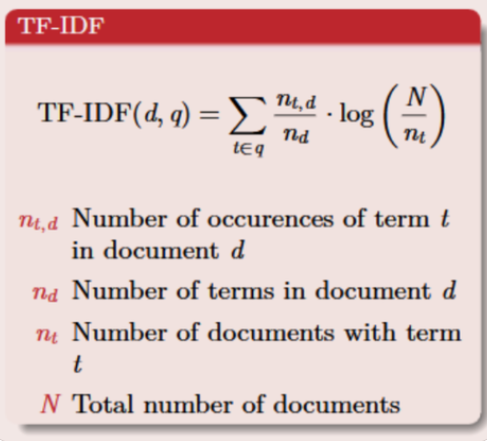

For træningsdata:

In [200]:
document_term_idf_matrix = np.empty((len(train_sentences),len(n_gram_keys_list)))

for i in range(len(train_sentences)):
    # print(train_sentences[i])
    tokens = train_sentences[i].split(" ")
    # print(tokens)
    for j in range(len(n_gram_keys_list)):
        term = n_gram_keys_list[j]
        ntd = 0
        if len(term.split(" ")) == 1: #unigram
            for z in range(len(tokens)):
                if tokens[z] == term:
                    ntd += 1

        if len(term.split(" ")) == 2: #bigram
            for z in range(len(tokens)-1):
                if tokens[z]+ " " + tokens[z+1] == term:
                    ntd += 1


        if len(term.split(" ")) == 3: #trigram
            for z in range(len(tokens)-2):
                if tokens[z]+ " " + tokens[z+1] + " " + tokens[z+2] == term:
                    ntd += 1

        nd = len(tokens)
        nt = alle_nt[term] # training_sentences n-gram vocabulary
        tf_idf = (ntd/nd) * math.log(len(train_sentences)/nt)

        # print(term,ntd,nd,nt,math.log(len(train_sentences)/nt),tf_idf)

        # smooth idf: 
        # print(math.log((1 + len(train_sentences)) / (1 + nt)) + 1)

        document_term_idf_matrix[i, j] = tf_idf

document_term_idf_matrix

array([[0.10356053, 0.15286681, 0.19093127, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.13202134, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [202]:
document_term_idf_matrix_df = pd.DataFrame(data = document_term_idf_matrix)
# document_term_idf_matrix_df.to_csv("DTTFIDFM_train.csv")

In [204]:
document_term_idf_matrix_df = pd.DataFrame(data = document_term_idf_matrix,  
                  index = train_sentences,  
                  columns = n_gram_keys_list) 
document_term_idf_matrix_df

,et,godt,nytår,ønsker,jeg,for,hele,det,grønlandske,folk,...,er dansk og,hvorfor skal vi,det bare ikke,op i vore,det kan kun,der er flere,røde og hvide,og hvide farver,lov at blomstre,noget der ikke
et godt nytår ønsker jeg for hele det grønlandske folk for hvert enkelt hjem i det fjerne nord,0.103561,0.152867,0.190931,0.191335,0.112897,0.142418,0.188574,0.097180,0.29255,0.246013,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
jeg er selv født med det danske samfunds muligheder inden for rækkevidde,0.000000,0.000000,0.000000,0.000000,0.178754,0.112748,0.000000,0.076934,0.00000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
lad os gå ind i det nye år med øjnene åbne for at vi alle er mennesker på godt og ondt,0.000000,0.132021,0.000000,0.000000,0.000000,0.061499,0.000000,0.041964,0.00000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
men jeg ser sådan på det at det er til gavn for os alle sammen at danmark hænger sammen,0.000000,0.000000,0.000000,0.000000,0.102145,0.064427,0.000000,0.087925,0.00000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sådan må det aldrig blive i danmark,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.131888,0.00000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mange synes det er sjovt,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.153869,0.00000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
både socialt og kulturelt har vi udbygget vort samfund på en måde som tidligere generationer næppe kunne forestille sig og den enkelte har fået udfoldelsesmuligheder som før var de færreste beskåret,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nytårsaften er der mange danske rundt omkring i verden som følger med i nytårsfejringen herhjemme,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hvorfor skal vi dog det,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.184643,0.00000,0.000000,...,0.0,1.561949,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


For testdata:

In [205]:
document_term_idf_matrix_test = np.zeros((len(test_sentences),len(n_gram_keys_list)))

for i in range(len(test_sentences)):
    # print(test_sentences[i])
    tokens = test_sentences[i].split(" ")
    # print(tokens)
    for j in range(len(n_gram_keys_list)):
        term = n_gram_keys_list[j]
        ntd = 0
        if len(term.split(" ")) == 1: #unigram
            for z in range(len(tokens)):
                if tokens[z] == term:
                    ntd += 1

        if len(term.split(" ")) == 2: #bigram
            for z in range(len(tokens)-1):
                if tokens[z]+ " " + tokens[z+1] == term:
                    ntd += 1


        if len(term.split(" ")) == 3: #trigram
            for z in range(len(tokens)-2):
                if tokens[z]+ " " + tokens[z+1] + " " + tokens[z+2] == term:
                    ntd += 1
        
        nd = len(tokens)
        nt = alle_nt.get(term, 0) # training_sentences n-gram vocabular

        if nt > 0:
            tf_idf = (ntd/nd) * math.log(len(train_sentences)/nt)
        else:
            tf_idf = 0
        # print(term,ntd,nd,nt,math.log(len(train_sentences)/nt),tf_idf)

        # smooth idf: 
        # print(math.log((1 + len(train_sentences)) / (1 + nt)) + 1)

        document_term_idf_matrix_test[i, j] = tf_idf

In [206]:
document_term_idf_matrix_test_df = pd.DataFrame(data = document_term_idf_matrix_test)
# document_term_idf_matrix_test_df.to_csv("DTTFIDFM_test.csv")

In [207]:
document_term_idf_matrix_test_df = pd.DataFrame(data = document_term_idf_matrix_test,  
                  index = test_sentences,  
                  columns = n_gram_keys_list) 
document_term_idf_matrix_test_df

,et,godt,nytår,ønsker,jeg,for,hele,det,grønlandske,folk,...,er dansk og,hvorfor skal vi,det bare ikke,op i vore,det kan kun,der er flere,røde og hvide,og hvide farver,lov at blomstre,noget der ikke
på årets sidste dag skal der lyde en tak for den modtagelse de gav os og et ønske om godt nytår for hver især et ønske der gælder danske hvor de end befinder sig i hele den vide verden enten båndene til danmark det gamle land er løsere eller meget nære er de ofte i vore tanker og altid med glæde og stolthed,0.052471,0.038726,0.048369,0.000000,0.000000,0.036079,0.047772,0.01231,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
bedre til at omsætte nye idéer til produktion og arbejdspladser,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
men udfaldet af den krig var også årsag til at sønderjyderne i 1920 kunne stemme sig tilbage til danmark,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
uden kinesisk støtte ville rusland ikke kunne angribe europa som de gør,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1979 gjorde at vi kom lidt i den rigtige retning,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
også for mange af de unge er situationen bekymrende,0.000000,0.000000,0.000000,0.000000,0.000000,0.150331,0.000000,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
danmark kan ikke løse verdens problemer alene,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tolv måneder er hurtigt forbi når man er travlt optaget og har meget at glæde sig over,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
på denne nytårsaften sender jeg mine varme hilsener og mine ønsker om et godt nytår for alle i grønland og på færøerne,0.089439,0.132021,0.164895,0.165243,0.097502,0.061499,0.000000,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Load 

In [211]:
train_tf_idf = pd.read_csv(r"DTTFIDFM_train.csv")
test_tf_idf = pd.read_csv(r"DTTFIDFM_test.csv")

In [212]:
train_tf_idf = train_tf_idf.drop('Unnamed: 0', axis=1)

In [213]:
test_tf_idf = test_tf_idf.drop('Unnamed: 0', axis=1)

# SVD (Singular Value decompostion)

In [1]:
# The following links have been used as guides for calculating and reducing the SVD
# https://www.geeksforgeeks.org/singular-value-decomposition-svd/ 
# https://machinelearningmastery.com/singular-value-decomposition-for-machine-learning/

In [2]:
# SVD er en metode der nedbryder en matrix til tre matricer.
# Formlen for SVD: A = U * singular * V^t
U, singular, V_transpose = svd(train_tf_idf, full_matrices=False) # Full_matrices = False fordi?? Jonathan siger det ja, men hvad ellers?

print("U: ", U) # mxm matrice med ortogonal egenvektorne af A * A^T
print("Singular array", singular) # diagnonaliseret matrice med elementer som er lig roden af de positive egenværdier af A * A^T
print("V^{T}", V_transpose) # n*n matrice der indeholder de ortogonale egenvektorværdier af A^T * A

NameError: name 'svd' is not defined

In [231]:
# Reducer dimensionaliteten
k = 200 # dimensionalitet
U_k = U[:, :k]
Vt_k = V_transpose[:k :,].T
Sigma = np.zeros((U.shape[0], k), dtype='float64')  # Keep only the first k singular values
np.fill_diagonal(Sigma, singular[:k])  # Populate Sigma with top k singular values

# To måder at reducere matrice på:
A_k = np.dot(U, Sigma)

In [233]:
np.savetxt("A_k200.csv", A_k, delimiter=",")